# Liverstage pipeline
This notebook showcases the most basic workflow of the liverstage pipeline. Briefly, the workflow is as follows: 
1) Parasite masks are generated using Mask R-CNN from a set of fluorescence microscopy images containing HSP70 and DAPI stainings.
2) From the DAPI channel we generate hepatocyte nucleus masks using Otsu thresholding and watershed segmentation. As a preprocessing step, parasite segmentations are subtracted from the DAPI channel as to not segment parasites as hepatocyte nuclei.
3) Feature extraction. User-specified features are extracted from the masks and any available channel.
4) A variational autoencoder (VAE) is trained on the extracted features. 
5) Features are embedded into the VAE's latent space.
6) Inter-group distances are calculated using the silhouette coefficient.

First off, some imports.

In [17]:
import sys
import os
sys.path.append(os.path.abspath('').split('LiverStagePipeline')[-2] + 'LiverStagePipeline')

import numpy as np
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import get_models as get_models
from segmentation.AI.datasets import MicroscopyDataset
from segmentation.evaluate import Inferenceinator
from segmentation.conventional.cell_watershed import segment_cells_in_folder as conv_seg


from utils import setup, data_utils, cell_viewer
from feature_analysis import features, plot_features
from feature_analysis.cell_dataset import CellDataset
from feature_analysis.VAE_models import VAE
from feature_analysis.train import train_VAE
from feature_analysis import inference, dimensionality_reduction, plot_lowdim, evaluate_clusters

torch.set_default_dtype(torch.float64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if not torch.cuda.is_available():
    print("Using non-cuda device: {}".format(device))

### Global settings
- **session_name** is the identifier for the current session, e.g. 'force_of_infection'.
- **output_folder** is the folder in which all output files will be stored, e.g. '/home/user/output'.
- **hsp_channel** and **dapi_channel** are the indices of the HSP- and DAPI channels within the images that are to be processed, respectively. Indices start from 0.
- **threads** is the number of processes that are allowed to be running simultaneously on the CPU.

In [18]:
session_name = '6c'
output_folder = '/mnt/DATA1/anton/pipeline_files'
# hsp_channel, dapi_channel = 1, 0 # lowres
hsp_channel, dapi_channel = 0, 2 # highres
threads = 20
normalization_folder_level = 6

next we set and create the required folders and paths:

In [19]:
paths = setup.setup(output_folder, session_name=session_name)

# Segmentation
- **model_path** is the path to the Mask R-CNN model used to segment parasites, e.g. '/home/user/model.pth'
- **segmentation_batch_size** is the number of images processed in parallel. More is faster but not better. The maximum number of images depends on the model, the GPU's VRAM and the image resolution. 
- **tif_folder** is the folder to where the fluorescence microscopy images are stored, in .tif format. E.g. '/home/user/tifs'.

In [20]:
model_path = '/mnt/DATA1/anton/pipeline_files/segmentation/models/best_model.pth'
segmentation_batch_size = 10

# tif_folder = '/mnt/DATA1/anton/data/force_of_infection/tifs'
# tif_folder = '/mnt/DATA1/anton/data/parasite_annotated_dataset/images/lowres/NF175'
tif_folder = '/mnt/DATA3/compounds/11C-organised'

to perform parasite segmentation:

In [21]:
image_paths = data_utils.get_paths(tif_folder) # list of paths to tif files
par_seg_stems = [os.path.basename(p) for p in data_utils.get_paths(paths['parasite_masks_folder'])] # stems of files within the designated parasite segmentation folder
image_paths_for_par_seg = [p for p in image_paths if not os.path.basename(p) in par_seg_stems] # set of tif files that has not already been segmented
channels = [[dapi_channel, hsp_channel] for img_path in image_paths_for_par_seg]

if len(image_paths_for_par_seg) > 0: # if there are images that are not yet segmented, then segment them:

    unique_normalization_levels = np.unique([p.split('/')[normalization_folder_level] for p in image_paths_for_par_seg]).tolist()
    normalization_mask = [unique_normalization_levels.index(p.split('/')[normalization_folder_level]) for p in image_paths_for_par_seg]
    print('Normalizing across these levels: {}'.format(unique_normalization_levels))

    segmentation_model, segmentation_model_output_parser = get_models.maskrcnn()
    segmentation_model.load_state_dict(torch.load(model_path))
    segmentation_model.to(device)

    image_dataset = MicroscopyDataset(image_paths=image_paths_for_par_seg, channels=channels, groups=None, normalize='min-max', normalization_mask=normalization_mask, rescale_img=(1040, 1392))
    image_loader = torch.utils.data.DataLoader(image_dataset, batch_size=segmentation_batch_size, num_workers=segmentation_batch_size, shuffle=True, collate_fn=data_utils.collate_fn)

    test_evaluator = Inferenceinator(image_loader, segmentation_model_output_parser, processes=segmentation_batch_size, evaluate=False, device=device)
    res = test_evaluator(segmentation_model, store_folder=paths['parasite_masks_folder'])
    print('Found {} segmented images, segmented {}.'.format(len(image_paths) - len(image_paths_for_par_seg), len(image_paths_for_par_seg)))
else:
    print('{} out of {} images were already segmented.'.format(len(image_paths), len(image_paths)))

10164 out of 10164 images were already segmented.


to perform hepatocyte nucleus segmentation:

In [22]:
image_paths, parasite_mask_paths = data_utils.get_two_sets(tif_folder, paths['parasite_masks_folder'], common_subset=True, return_paths=True)
hep_seg_stems = [os.path.basename(p) for p in data_utils.get_paths(paths['hepatocyte_masks_folder'])] # stems of files within the designated hepatocyte segmentation folder
hep_seg_mask = [True if os.path.basename(p) in hep_seg_stems else False for p in image_paths] # list of binary values indicating for which images the hepatocytes have been segmented
image_paths_for_hep_seg = [value for value, flag in zip(image_paths, hep_seg_mask) if not flag]
parasite_seg_paths_for_hep_seg = [value for value, flag in zip(parasite_mask_paths, hep_seg_mask) if not flag]
DAPI_channels = [dapi_channel] * len(image_paths_for_hep_seg)

if len(image_paths_for_hep_seg) > 0:
    conv_seg(image_paths=image_paths_for_hep_seg, segmentation_folder=paths['hepatocyte_masks_folder'], parasite_mask_paths=parasite_seg_paths_for_hep_seg, threads=threads, channels=DAPI_channels, resize_shape=None, normalize=False, equalize_adapthist=12)
    print('Found {} segmented images, segmented {}.'.format(len(image_paths) - len(image_paths_for_hep_seg), len(image_paths_for_hep_seg)))
else:
    print('{} out of {} images were already segmented.'.format(len(image_paths), len(image_paths)))

10164 out of 10164 images were already segmented.


Now to visualize the segmentations:

/mnt/DATA3/compounds/11C-organised/LDN/23B/hGS/Exp2021023B-01-Scene-15-C7-C07_series_42_Exp2021023B-01-Scene-15-C7-C07


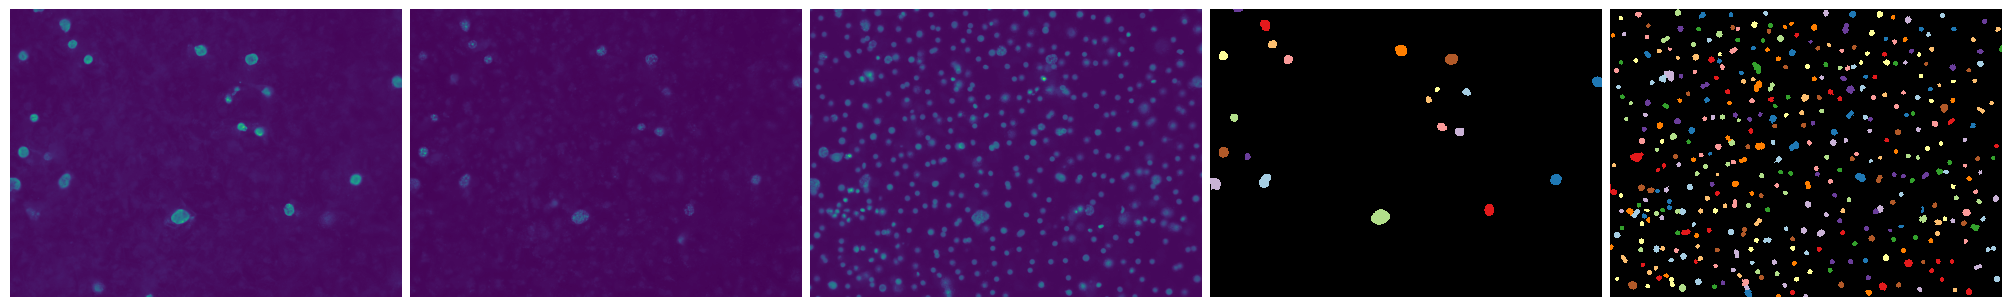

/mnt/DATA3/compounds/11C-organised/5C/23D/EXP2/Exp2021023D-01-Scene-07-B8-B08_series_74_Exp2021023D-01-Scene-07-B8-B08


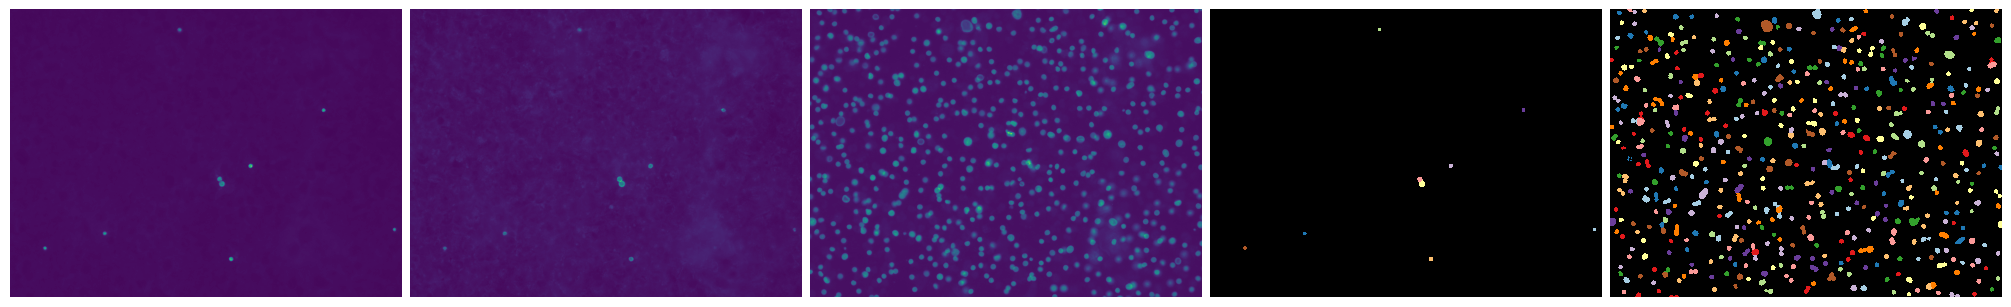

In [23]:
cell_viewer.show_folder(tif_dir=tif_folder, seg_dirs=[paths['parasite_masks_folder'], paths['hepatocyte_masks_folder']], eval=False, num_rows=1, num_images=2)

# Feature extraction
Extract features from the generated masks and any available channel. 

### Settings:
- **metadata_func**: method that accepts a tif path and outputs relevant metadata (e.g. strain, day, resolution, etc.) used to distinguish images. Output of the method should be in dictionary form. E.g. {'strain': 54, 'day': 7}. Output of the metadata_func is stored in the .csv file alongside the extracted features.
- **feature_dict**: dictionary indicating which features need to be computed, formatted as {*ID*: (*name*, *feature_list*)}, where *ID* is either the index of the channel or 'mask' for mask related features. *name* is the suffix for the computed feature in the final csv file. *feature_list* is a list of features. A feature_dict could be {'mask': ('', ['area', 'solidity']), 1: ('hsp', ['max_intensity', 'min_intensity'])}. A predefined *feature_dict* can be imported using features.default_feature_dict(hsp_channel=hsp_channel, dapi_channel=dapi_channel).

In [24]:
# settings
parasite_mask_features = [
    # Area
    # Convex area
    # Filled area
    # Axis major length
    # Axis minor length
    # Eccentricity
    # Equivalent diameter area
    # Extent
    # Maximum Feret diameter
    # Perimeter
    # Crofton's perimeter
    # Solidity
    'area', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'eccentricity', 
    'equivalent_diameter_area', 'extent', 'feret_diameter_max', 'perimeter', 'perimeter_crofton', 'solidity', 

    # Average N nearest parasites distance
    # Parasites within N pixels
    'avg_(1)_neighbours_distance', 'avg_(3)_neighbours_distance', 'avg_(5)_neighbours_distance', 'avg_(7)_neighbours_distance',
    'parasites_within_(100)px', 'parasites_within_(300)px', 'parasites_within_(600)px', 
    'parasites_within_(900)px', 'parasites_within_(1200)px', 'parasites_within_(2000)px'   
    ]

hepatocyte_mask_features = [
    # Average N nearest hepatocytes distance
    'avg_(1)_nearest_hepatocytes_distance', 'avg_(3)_nearest_hepatocytes_distance', 'avg_(5)_nearest_hepatocytes_distance', 
    'avg_(7)_nearest_hepatocytes_distance', 'avg_(10)_nearest_hepatocytes_distance', 'avg_(15)_nearest_hepatocytes_distance', 
    'avg_(20)_nearest_hepatocytes_distance', 'avg_(50)_nearest_hepatocytes_distance', 'avg_(100)_nearest_hepatocytes_distance', 

    # Hepatocytes within N pixel radius
    'num_hepatocytes_in_(100)px_radius', 'num_hepatocytes_in_(300)px_radius', 'num_hepatocytes_in_(600)px_radius', 'num_hepatocytes_in_(900)px_radius', 

    # Hepatocytes within N pixel radius average area
    'avg_hepatocyte_area_(100)px_radius', 'avg_hepatocyte_area_(300)px_radius', 'avg_hepatocyte_area_(600)px_radius', 'avg_hepatocyte_area_(900)px_radius',

    # Hepatocytes within N pixel radius average eccentricity
    'avg_hepatocyte_eccentricity_(100)px_radius', 'avg_hepatocyte_eccentricity_(300)px_radius', 'avg_hepatocyte_eccentricity_(600)px_radius', 
    'avg_hepatocyte_eccentricity_(900)px_radius', 
]


dapi_channel_features = [
    # Average intensity, intensity standard deviation, minimum intensity, maximum intensity, intensity sum
    'avg_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'intensity_sum',

    # N pixel radius average intensity
    'avg_(50)px_radius_intensity', 'avg_(100)px_radius_intensity', 'avg_(300)px_radius_intensity',
                            
    # Hepatocytes within N pixel radius average intensity
    'avg_hepatocyte_intensity_(100)px_radius', 'avg_hepatocyte_intensity_(300)px_radius', 'avg_hepatocyte_intensity_(600)px_radius', 'avg_hepatocyte_intensity_(900)px_radius', 

    # # Hepatocytes within N pixel radius average minimum intensity
    'min_hepatocyte_intensity_(100)px_radius', 'min_hepatocyte_intensity_(300)px_radius', 'min_hepatocyte_intensity_(600)px_radius', 'min_hepatocyte_intensity_(900)px_radius', 

    # # Hepatocytes within N pixel radius average maximum intensity
    'max_hepatocyte_intensity_(100)px_radius', 'max_hepatocyte_intensity_(300)px_radius', 'max_hepatocyte_intensity_(600)px_radius', 'max_hepatocyte_intensity_(900)px_radius']

hsp_channel_features = [
    # Average intensity, intensity standard deviation, minimum intensity, maximum intensity, intensity sum
    'avg_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'intensity_sum',

    # N pixel radius average intensity
    'avg_(50)px_radius_intensity', 'avg_(100)px_radius_intensity', 'avg_(300)px_radius_intensity'
]

# Cell intensity ratio
# feature_dict = {'mask': ('', parasite_mask_features + hepatocyte_mask_features)}
feature_dict = {
    'mask': ('', parasite_mask_features + hepatocyte_mask_features),
    0: ('hsp', hsp_channel_features),
    1: ('green', hsp_channel_features),
    2: ('dapi', dapi_channel_features + ['cell_intensity_ratio'])
}

def sixc_metadata(tif_path):
    return {'drug': tif_path.split('/')[5], 'experiment': tif_path.split('/')[6], 'green_stain': tif_path.split('/')[7]}

metadata_func = sixc_metadata

print('Normalizing across these levels: {}'.format(set([p.split('/')[normalization_folder_level] for p in image_paths])))
print(feature_dict)

Normalizing across these levels: {'23D', '25A', '23B', '25C'}
{'mask': ('', ['area', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'equivalent_diameter_area', 'extent', 'feret_diameter_max', 'perimeter', 'perimeter_crofton', 'solidity', 'avg_(1)_neighbours_distance', 'avg_(3)_neighbours_distance', 'avg_(5)_neighbours_distance', 'avg_(7)_neighbours_distance', 'parasites_within_(100)px', 'parasites_within_(300)px', 'parasites_within_(600)px', 'parasites_within_(900)px', 'parasites_within_(1200)px', 'parasites_within_(2000)px', 'avg_(1)_nearest_hepatocytes_distance', 'avg_(3)_nearest_hepatocytes_distance', 'avg_(5)_nearest_hepatocytes_distance', 'avg_(7)_nearest_hepatocytes_distance', 'avg_(10)_nearest_hepatocytes_distance', 'avg_(15)_nearest_hepatocytes_distance', 'avg_(20)_nearest_hepatocytes_distance', 'avg_(50)_nearest_hepatocytes_distance', 'avg_(100)_nearest_hepatocytes_distance', 'num_hepatocytes_in_(100)px_radius', 'num_hepatocytes_in_(300

The next codeblock is for extracting features from the images, which may take some time depending on the computer. Note that when a .csv file exists in the designated path for features, the images of which features are contained in the .csv file are not processed again, meaning you can restart the cell and the feature extraction will continue at the same point.

In [25]:
# feature extraction
features.collect_features_from_folder(tif_folder=tif_folder, parasite_mask_folder=paths['parasite_masks_folder'], feature_dict=feature_dict, hepatocyte_mask_folder=paths['hepatocyte_masks_folder'], 
                                      csv_path=paths['feature_file'], completed_files_path=paths['features_completed_file'], metadata_func=metadata_func, workers=threads, normalization_folder_level=normalization_folder_level)

10164 files already processed. Skipping those.
0 0


0it [00:00, ?it/s]

Total progression: 0it [00:00, ?it/s]

80 features extracted from 215992 cells in 10139 images.


drug experiment green_stain  \
0       LDN        25C        MSP1   
1       LDN        25C        MSP1   
2       LDN        25C        MSP1   
3       LDN        25C        MSP1   
4       LDN        25C        MSP1   
...     ...        ...         ...   
215987   WB        23D        MSP1   
215988   WB        23D        MSP1   
215989   WB        23D        MSP1   
215990   WB        23D        MSP1   
215991   WB        23D        MSP1   

                                                     file  label  \
0       Exp2021025C-01-Scene-26-D7-D07_series_21_Exp20...      1   
1       Exp2021025C-01-Scene-26-D7-D07_series_21_Exp20...      2   
2       Exp2021025C-01-Scene-26-D7-D07_series_21_Exp20...      3   
3       Exp2021025C-01-Scene-26-D7-D07_series_21_Exp20...      4   
4       Exp2021025C-01-Scene-26-D7-D07_series_21_Exp20...      5   
...                                                   ...    ...   
215987  Exp2021023D-01-Scene-28-D9-D09_series_45_Exp20...      2   
215988  Exp2021023D-01-Scene-28-D9-D09_series_45_Exp20...      3   
215989  Exp2021023D-01-Scene-28-D9-D09_series_45_Exp20...      4   
215990  Exp2021023D-01-Scene-28-D9-D09_series_45_Exp20...      5   
215991  Exp2021023D-01-Scene-28-D9-D09_series_45_Exp20...      6   

        perimeter_crofton  area_convex   perimeter  solidity    extent  ...  \
0              470.221138      14257.0  493.154329  0.980992  0.856775  ...   
1              506.612188      16116.0  531.539105  0.975180  0.797119  ...   
2              346.283297       8049.0  362.426407  0.977761  0.856272  ...   
3              320.848353       6876.0  335.597980  0.976149  0.847796  ...   
4              332.359819       6540.0  347.740115  0.947554  0.708877  ...   
...                   ...          ...         ...       ...       ...  ...   
215987         442.009393      12670.0  463.396970  0.974033  0.816582  ...   
215988         316.500755       6575.0  331.012193  0.969582  0.828460  ...   
215989         435.535638      12565.0  456.568542  0.979626  0.841238  ...   
215990         250.001840       3207.0  260.870058  0.958528  0.772944  ...   
215991         235.062927       3690.0  245.112698  0.972358  0.837535  ...   

        avg_hepatocyte_intensity_100px_radius_dapi  \
0                                              NaN   
1                                         2.687295   
2                                         2.503317   
3                                         2.681669   
4                                         1.868391   
...                                            ...   
215987                                         NaN   
215988                                    1.556664   
215989                                    2.069307   
215990                                    1.900314   
215991                                    1.045199   

        avg_100px_radius_intensity_dapi  max_intensity_dapi  \
0                             -0.261905            6.229841   
1                             -0.178865            4.569856   
2                             -0.155150            6.910250   
3                             -0.197125            6.812292   
4                             -0.092214            6.227194   
...                                 ...                 ...   
215987                        -0.271496            5.760839   
215988                        -0.070277            6.876977   
215989                        -0.148656            5.681710   
215990                         0.214879            3.678493   
215991                        -0.082626            3.445270   

        min_hepatocyte_intensity_600px_radius_dapi  \
0                                         0.789917   
1                                         0.939201   
2                                         0.936984   
3                                         0.867424   
4                                         0.917745   
...                                            ...   


In [27]:
comparison_groups = list(metadata_func(image_paths[0]).keys()) # list of metadata categories
non_feature_columns = comparison_groups + ['file', 'label'] # list of columns in the .csv file to not use for downstream processing

df = pd.read_csv(paths['feature_file']) # read the .csv file into memory

### Creating a subset of features and/or parasites
We may want to only perform downstream processing on a subset of the extracted parasites, for instance those belonging to the NF175 strain. Alternatively, we may want to only use a subset of the extracted features. In these cases we need to replace the dataframe containing the features by a subset of itself containing only relevant information. Note that metadata groups and 'file' and 'label' don't need to be removed.

To limit ourselves to only NF175 parasites, we may do:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;df = df[df['strain'] == '175']

Or, to drop the columns 'area' and 'eccentricity', we may do:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;df = df.drop(columns=['area', 'eccentricity'])

- **subset_identifier**: an identifier to distinguish different subsets 


In [28]:
subset_identifier = 'RelDrugs_hsp-dapi'#'AllDrugs_hGS'#

## subset the dataframe here
# df = df[df['green_stain']=='hGS']
df = df[df['drug'].isin(['B27', 'SB', 'CHIR', 'Forskolin', '5C', 'IWP2', 'ForskSB', 'LDN', 'DAPT'])]
df = df.drop(columns=['std_intensity_green','min_intensity_green','intensity_sum_green','avg_intensity_green','avg_100px_radius_intensity_green','avg_50px_radius_intensity_green','avg_300px_radius_intensity_green','max_intensity_green'])

These are the current metadata categories:

In [29]:
for g in comparison_groups:
    print('Category: {}, unique values: {}'.format(g, df[g].unique()))

Category: drug, unique values: ['LDN' 'DAPT' 'IWP2' 'Forskolin' 'SB' '5C' 'CHIR' 'ForskSB' 'B27']
Category: experiment, unique values: ['25C' '23D' '25A' '23B']
Category: green_stain, unique values: ['MSP1' 'hGS' 'EXP2']


And this is the complete list of features we are currently working with:

In [30]:
print([f for f in df.columns if f not in non_feature_columns])

['perimeter_crofton', 'area_convex', 'perimeter', 'solidity', 'extent', 'axis_minor_length', 'equivalent_diameter_area', 'eccentricity', 'area_filled', 'area', 'feret_diameter_max', 'axis_major_length', 'avg_hepatocyte_eccentricity_100px_radius', 'num_hepatocytes_in_600px_radius', 'parasites_within_1200px', 'avg_hepatocyte_area_100px_radius', 'num_hepatocytes_in_900px_radius', 'parasites_within_900px', 'avg_20_nearest_hepatocytes_distance', 'avg_50_nearest_hepatocytes_distance', 'avg_hepatocyte_area_600px_radius', 'avg_hepatocyte_eccentricity_600px_radius', 'avg_hepatocyte_eccentricity_300px_radius', 'avg_hepatocyte_eccentricity_900px_radius', 'parasites_within_600px', 'parasites_within_100px', 'avg_5_nearest_hepatocytes_distance', 'avg_7_neighbours_distance', 'avg_3_neighbours_distance', 'avg_5_neighbours_distance', 'avg_hepatocyte_area_900px_radius', 'avg_15_nearest_hepatocytes_distance', 'avg_100_nearest_hepatocytes_distance', 'avg_10_nearest_hepatocytes_distance', 'num_hepatocytes_

# Plotting features
Next, for each feature, we compare the density distribution between experimental factors contained in the metadata.
- **label_settings** can be used to change the order and names of experimental factors within plots. It is formatted as follows: {'exp_factor': [['old_name1', 'new_name1'], ['old_name2', 'new_name2']]}. Here, exp_factor is the experimental factor contained in the metadata, such as 'strain' or 'day'. old_name is how the label occurs throughout the feature file and new_name is its new name, e.g. ['54.0', 'NF54']. Alternatively, label_settings can be set to None to not make any changes.

In [31]:
label_settings = {'foi': 
                        [['8s1h', '$\dfrac{8}{1}$'], 
                        ['4s1h', '$\dfrac{4}{1}$'],
                        ['2s1h', '$\dfrac{2}{1}$'],
                        ['1s1h', '$\dfrac{1}{1}$'],
                        ['1s2h', '$\dfrac{1}{2}$'],
                        ['1s4h', '$\dfrac{1}{4}$'],
                        ['1s8h', '$\dfrac{1}{8}$'],
                        ['1s16h', '$\dfrac{1}{16}$'],
                        ['1s32h', '$\dfrac{1}{32}$']],
                   'strain': 
                   [
                    ['54', 'NF54'],
                    ['135', 'NF135'],
                    ['175', 'NF175']
                   ],
                   'day':
                   [['3', 'D3'],
                    ['5', 'D5'],
                    ['7', 'D7']],
                    'drug':
                    [['B27', 'control'], ['LDN', 'LDN'], ['IWP2', 'IWP2'], ['DAPT', 'DAPT'], ['SB', 'SB'], ['CHIR', 'CHIR'], ['Forskolin', 'Forskolin'], ['ForskSB', 'Forsk + SB'], ['5C', '5C'], ['WBH', 'WBH'],['WB','WB']],
                    }

To plot the features:

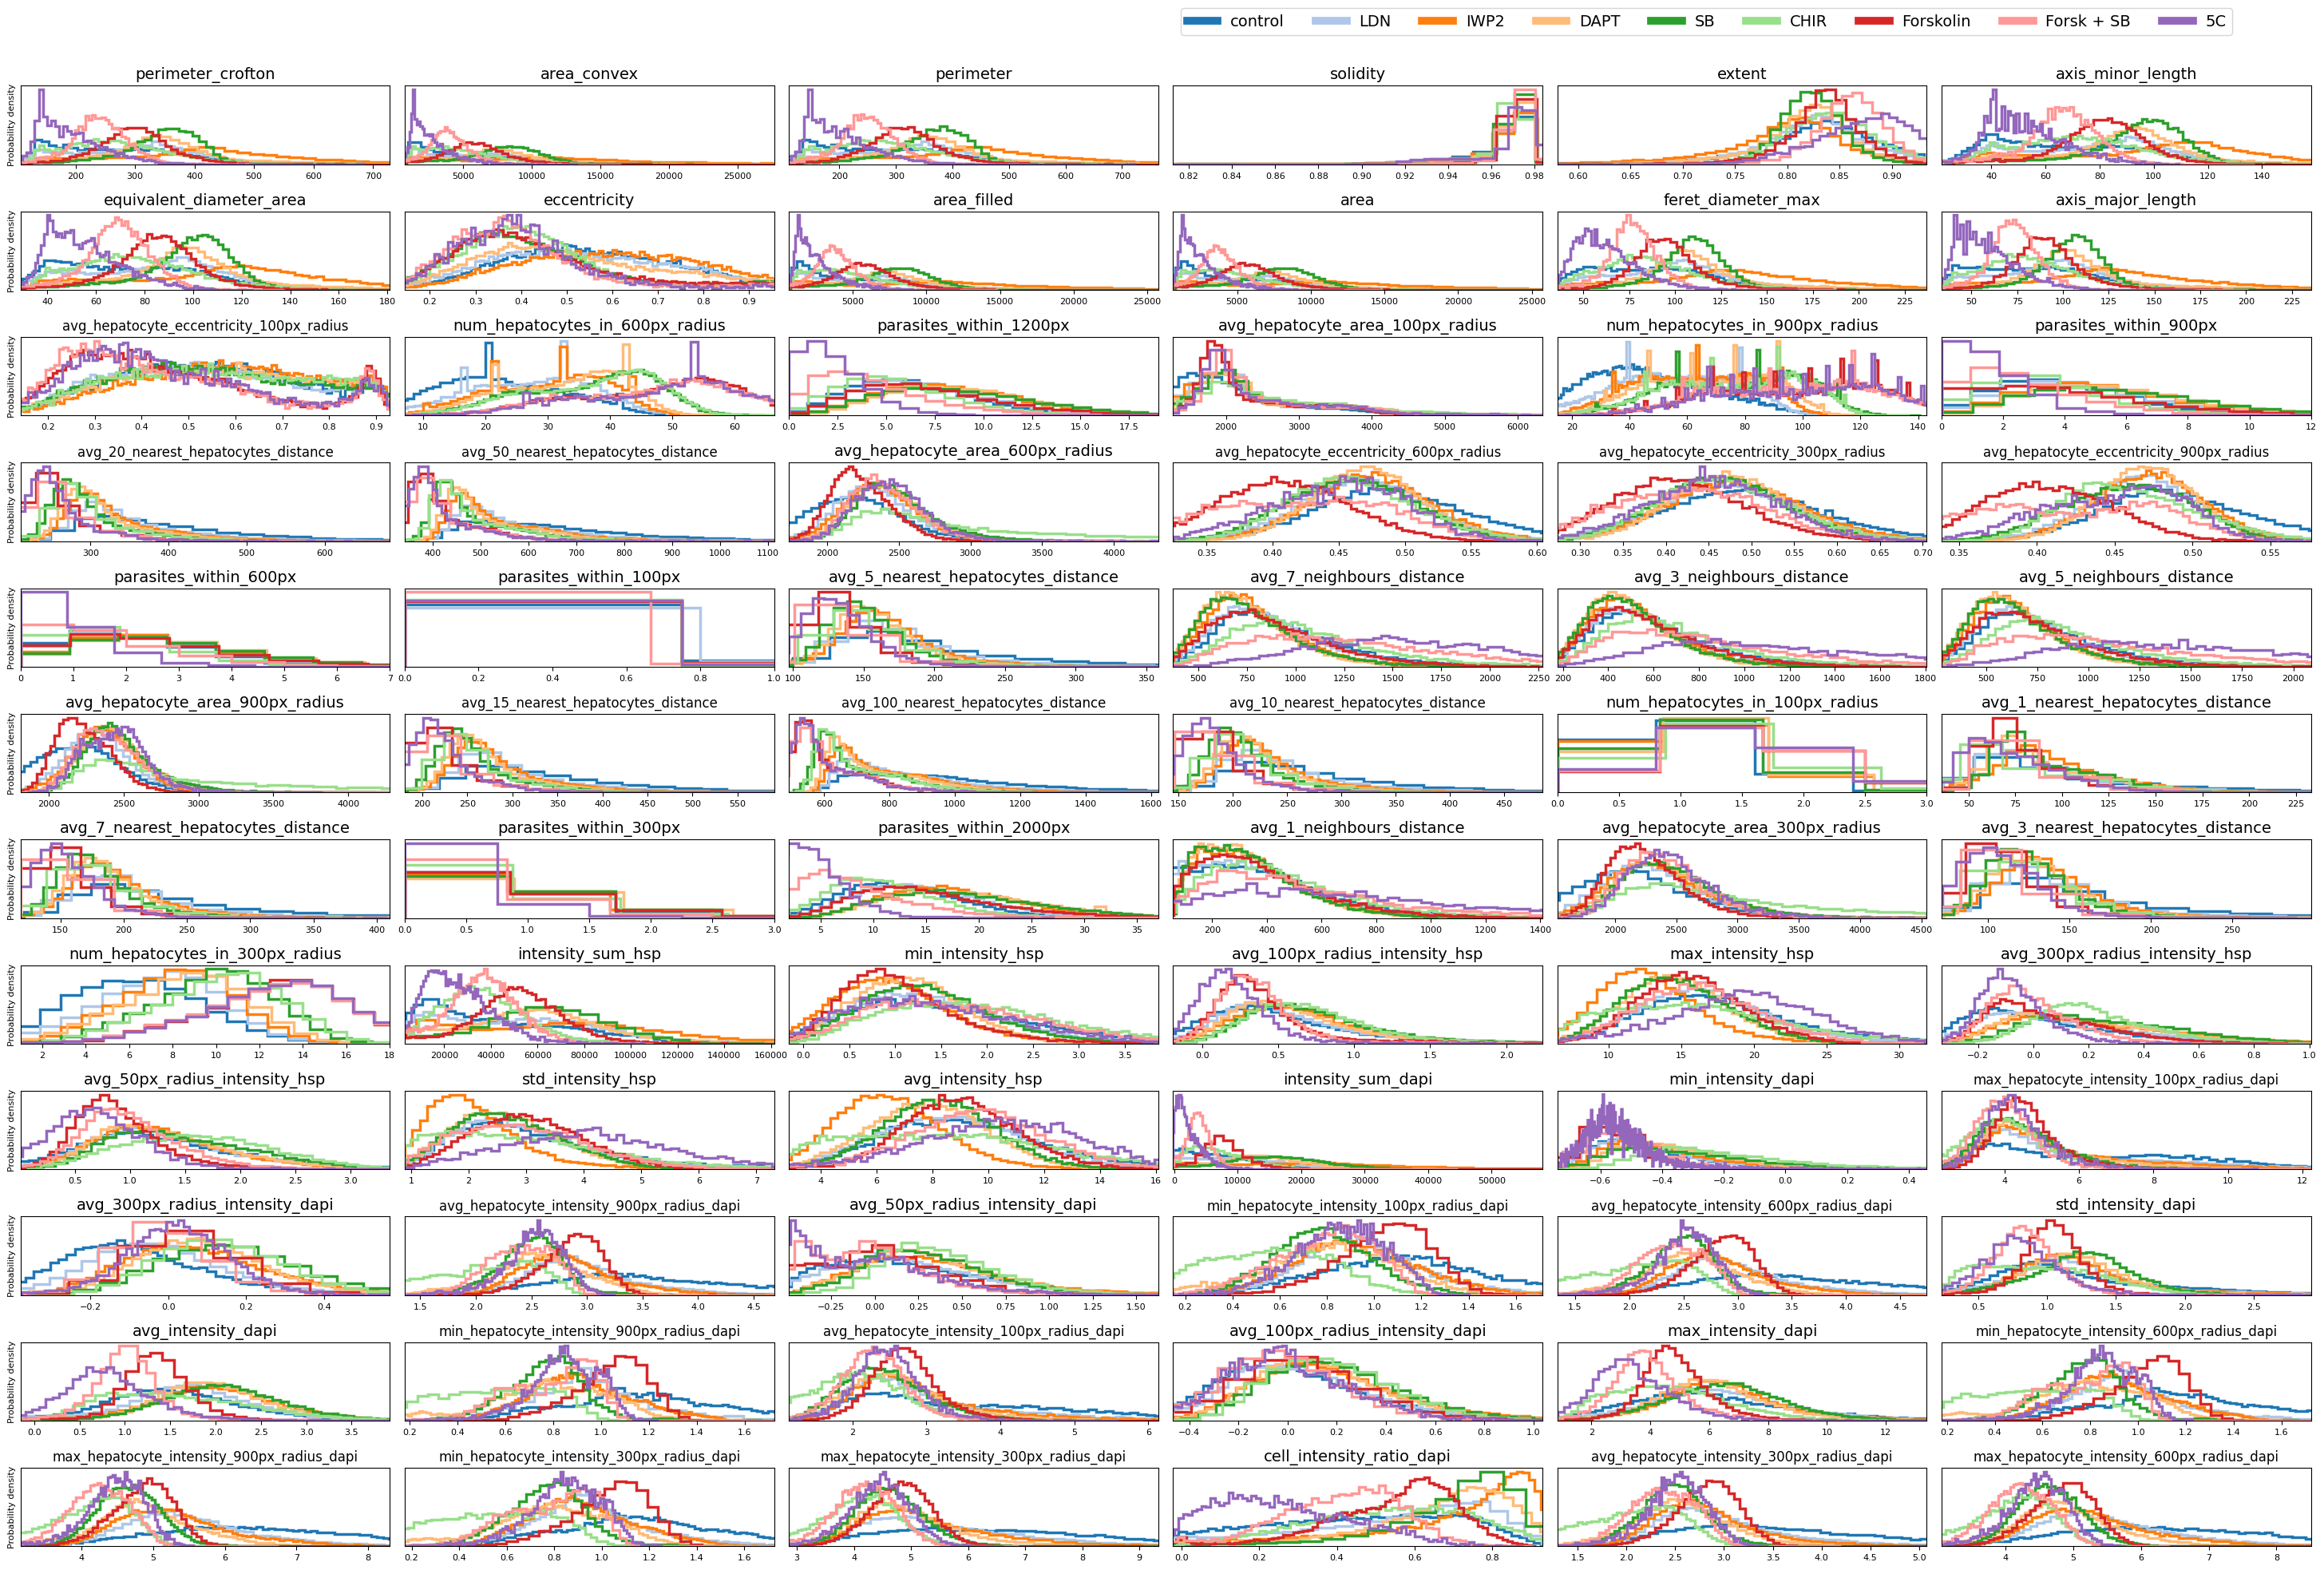

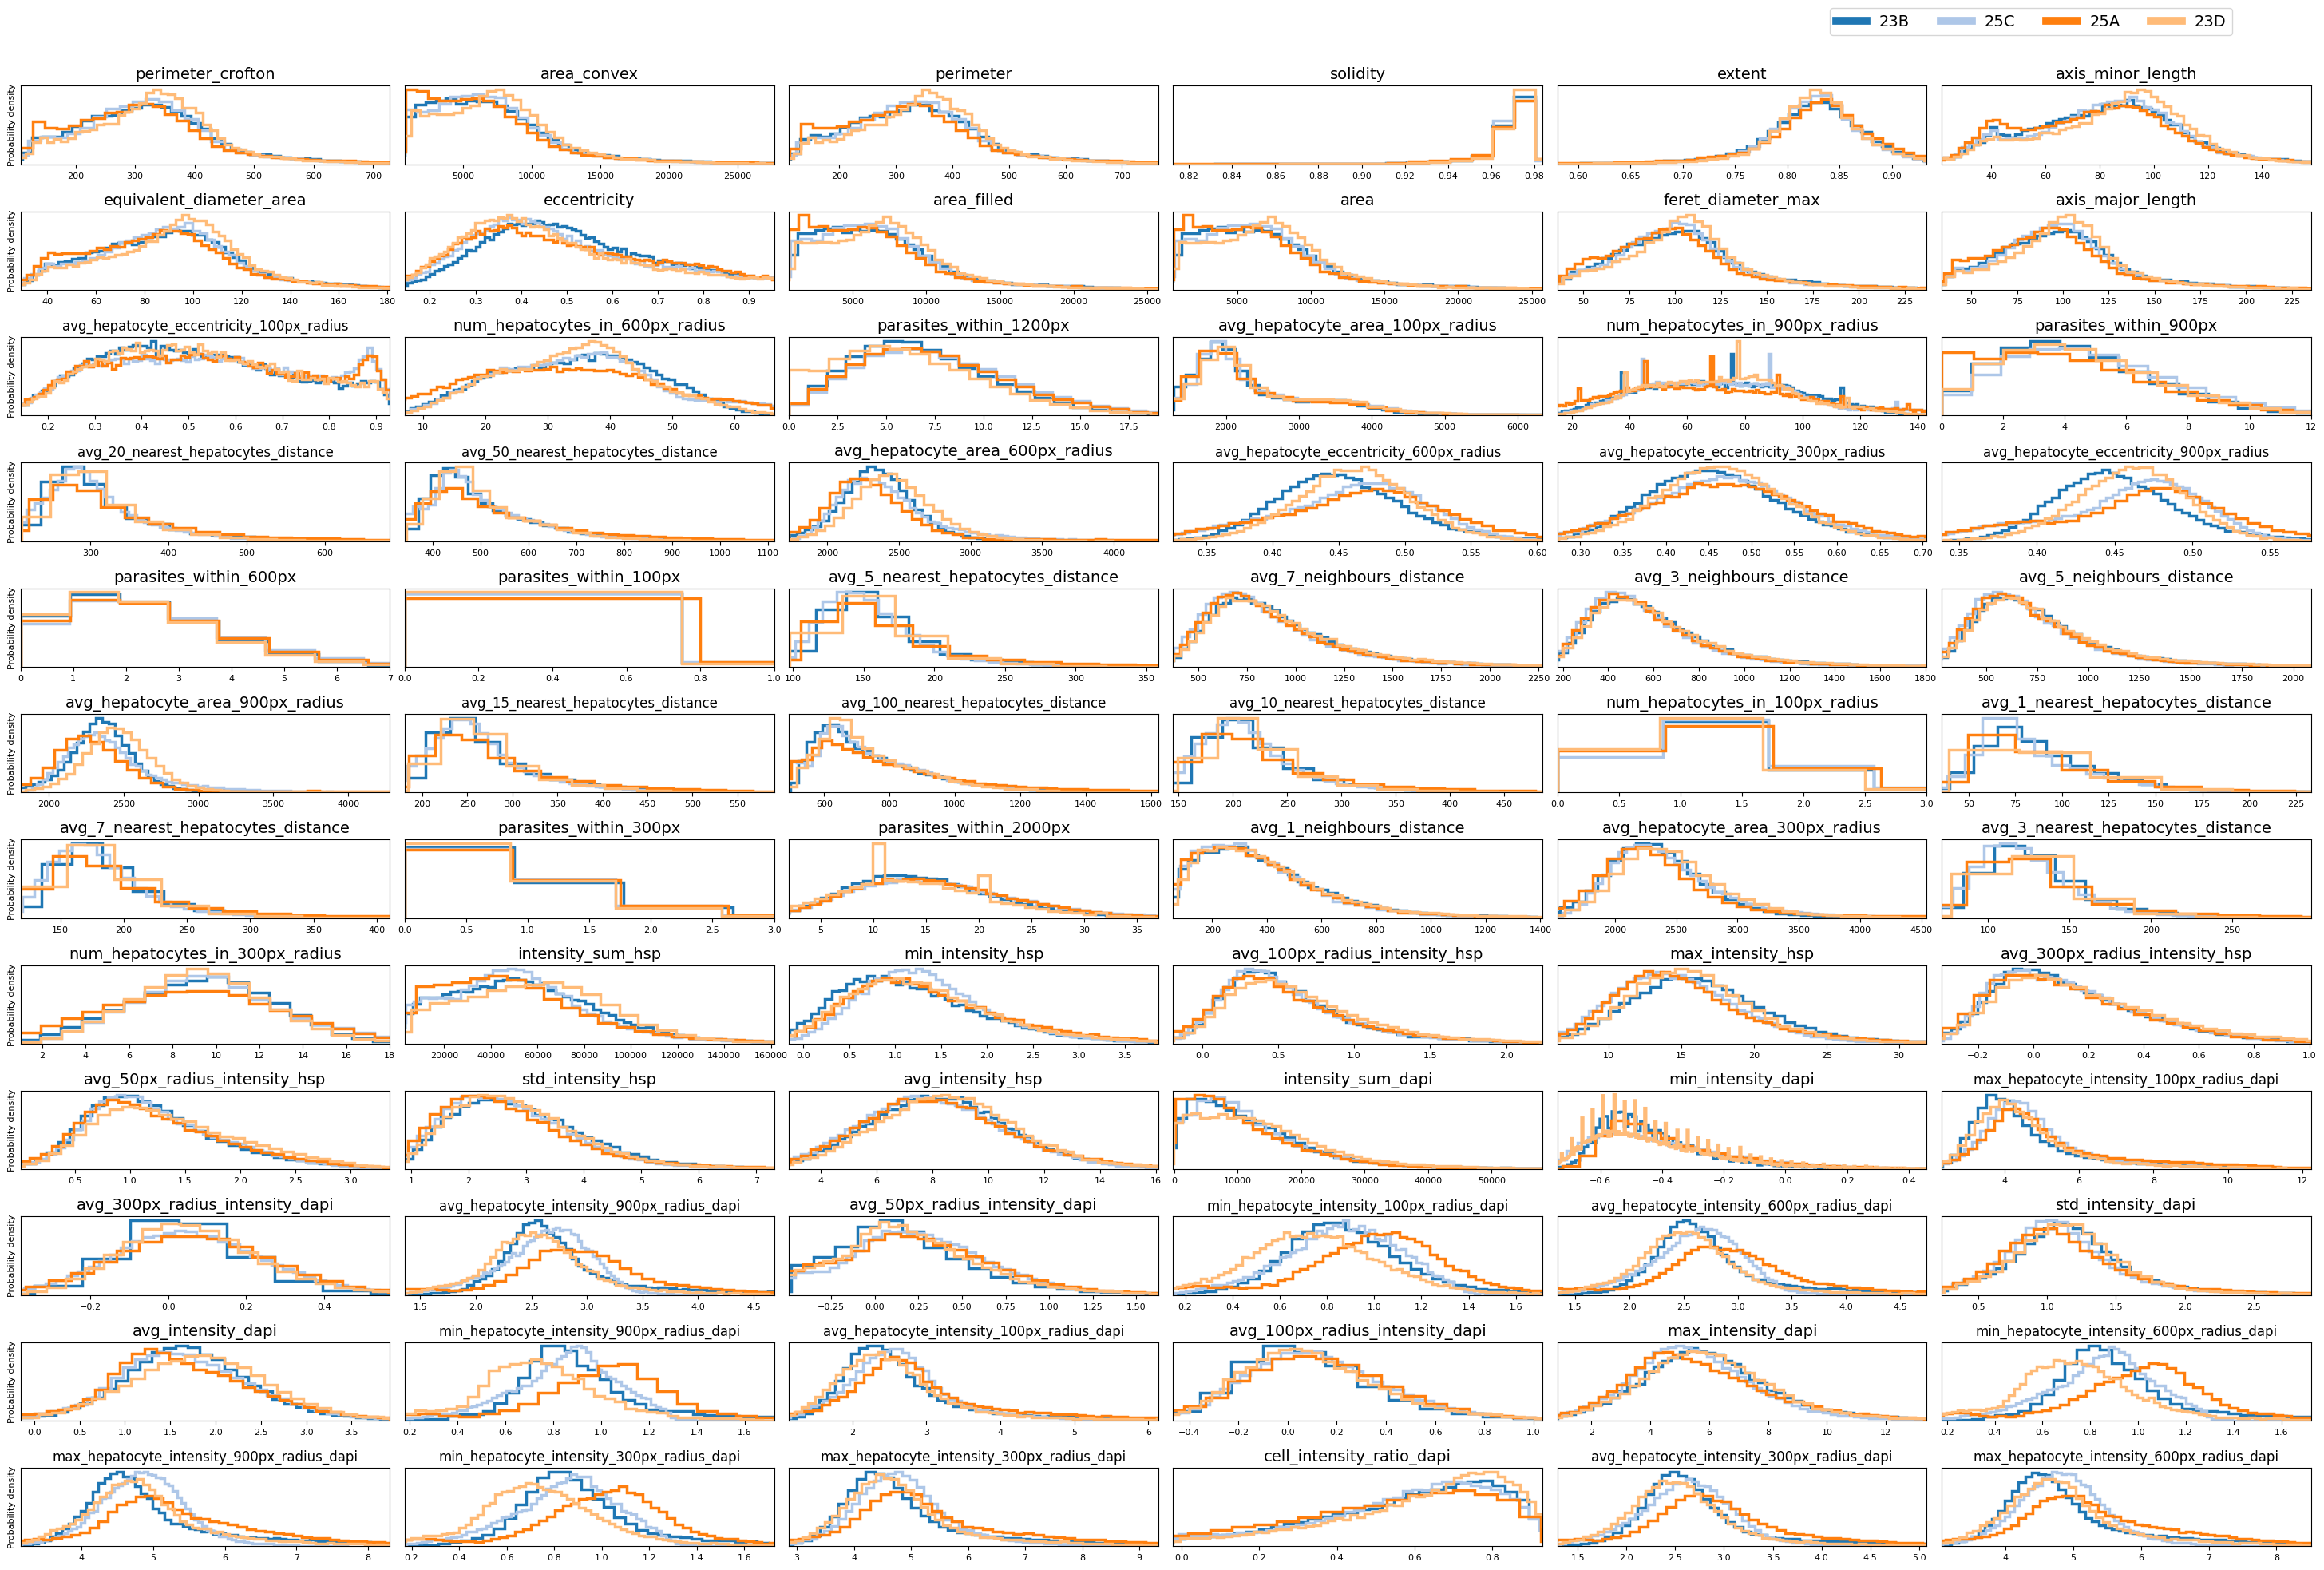

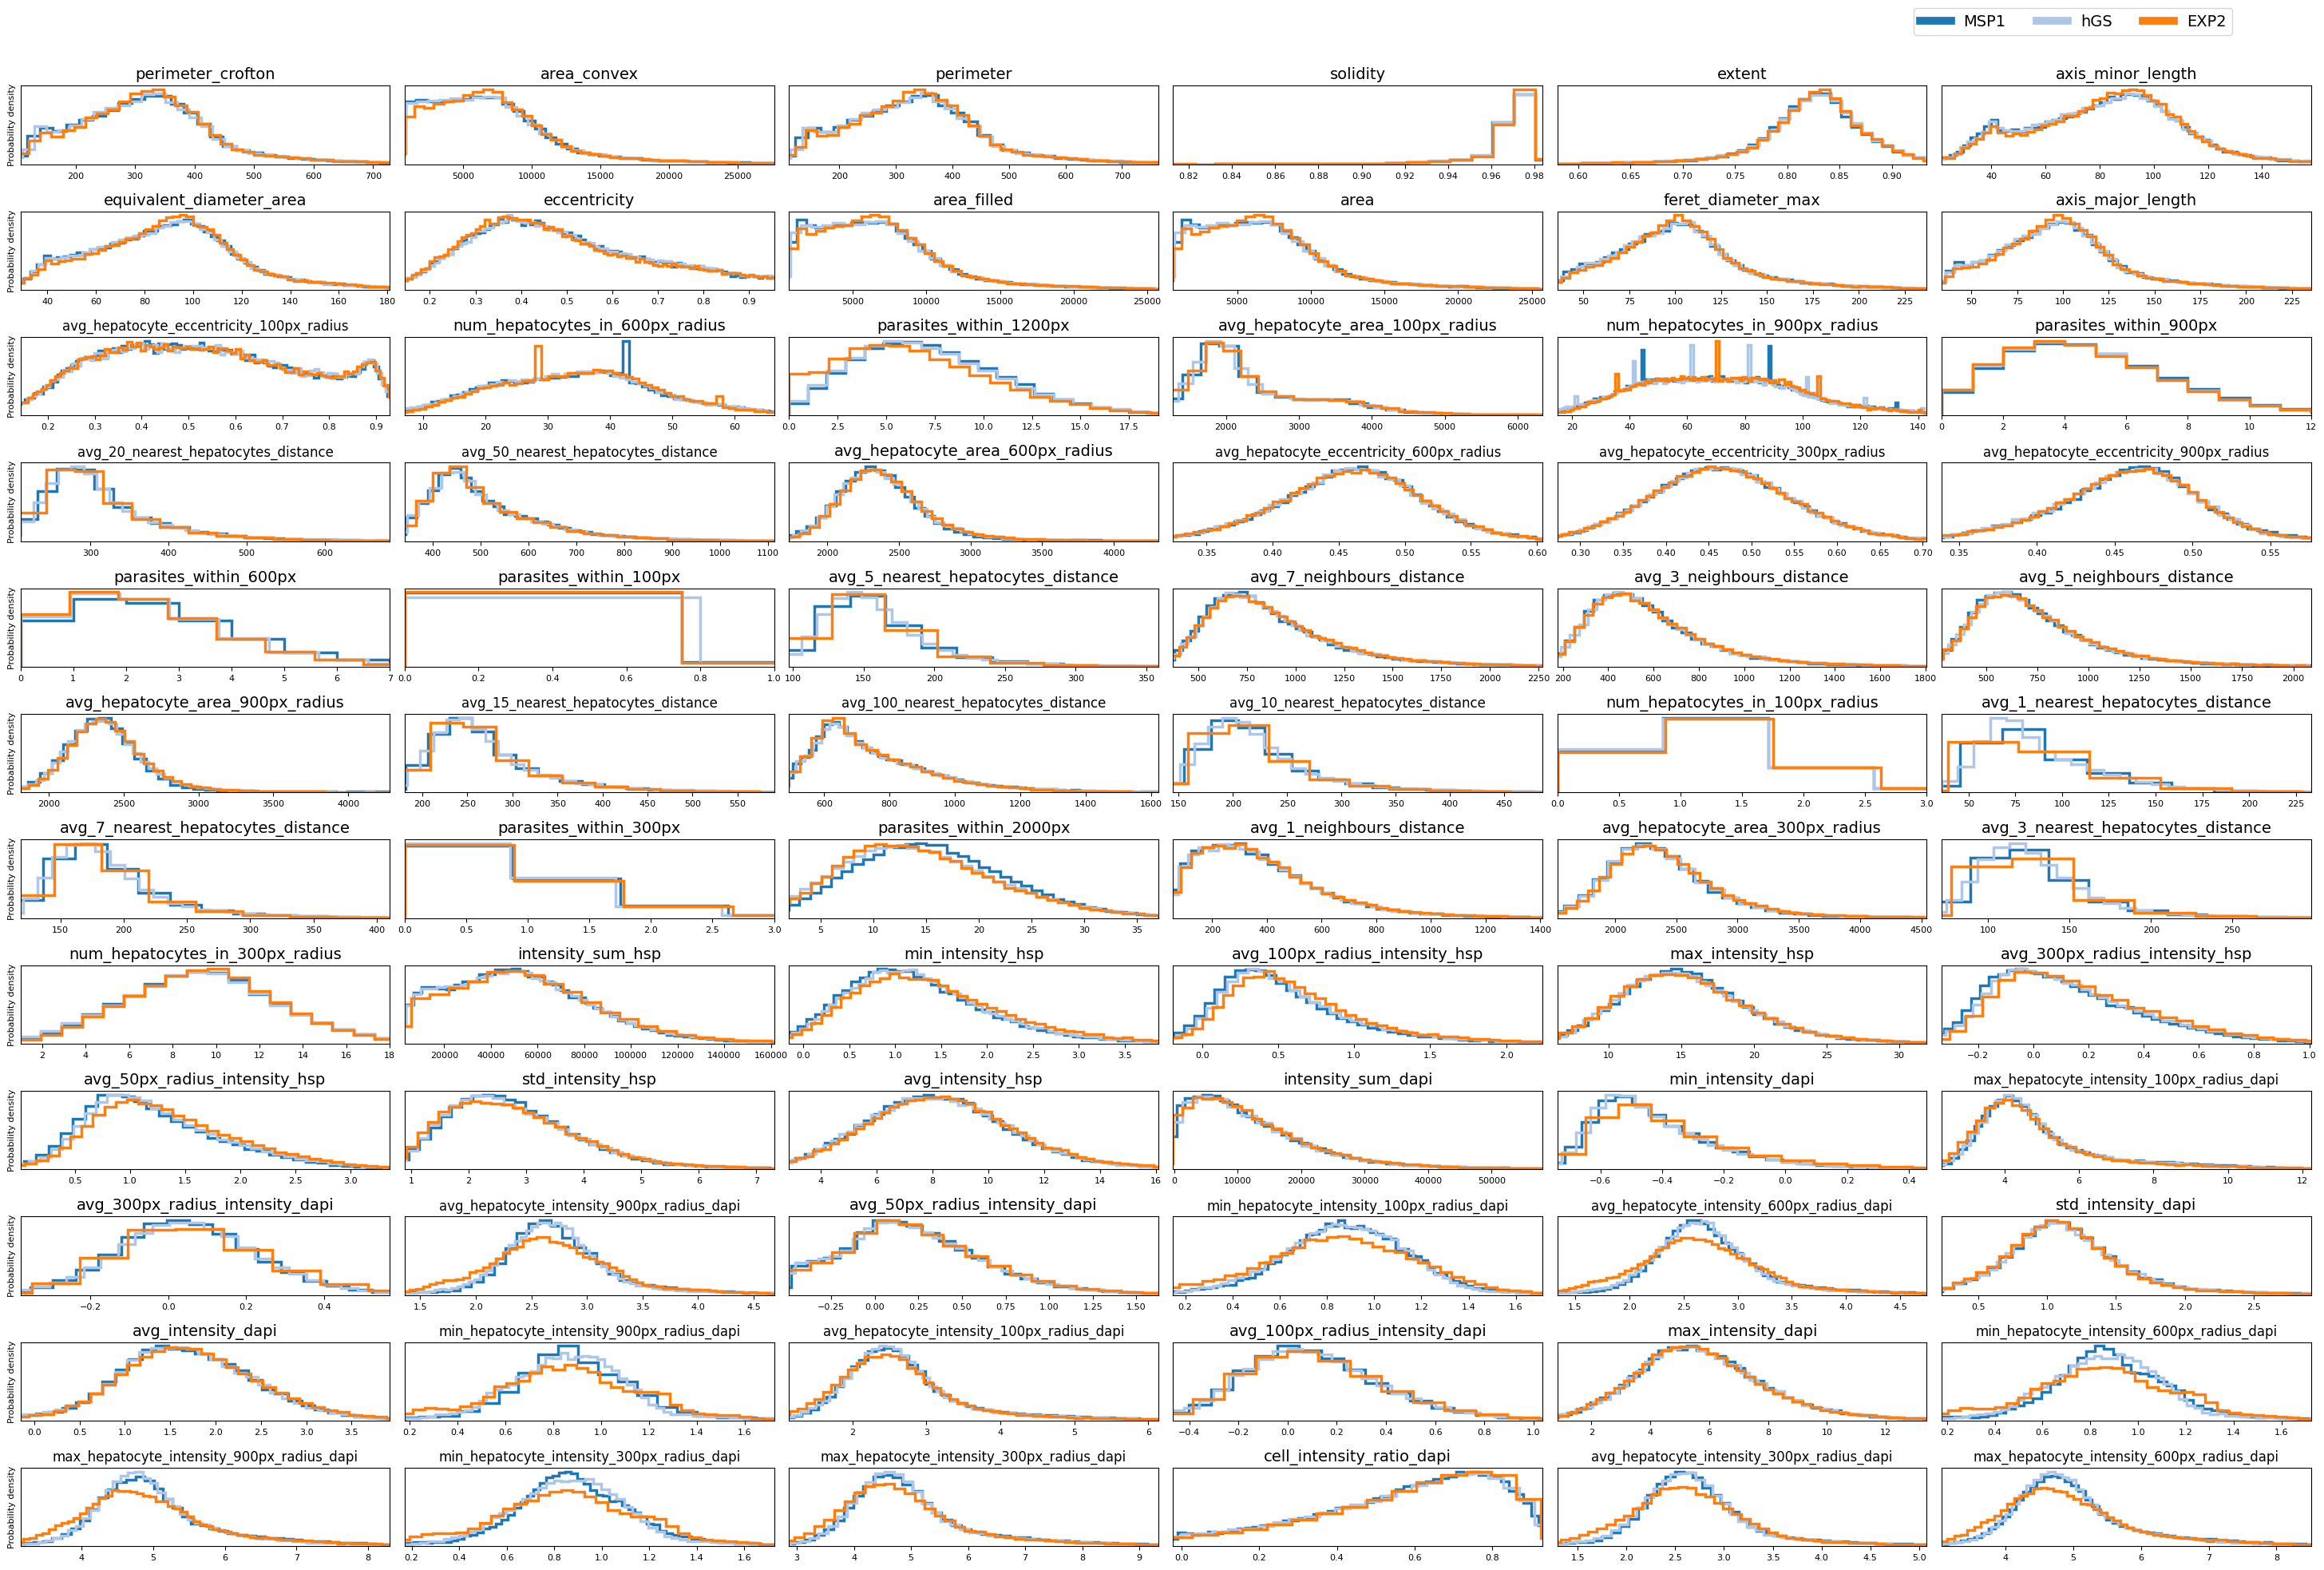

In [32]:
features_df = df.drop(columns=non_feature_columns)

for grouping in comparison_groups:
    labels = df[grouping]
    multiplot_path = os.path.join(paths['FA_features_multiplot_folder'], '{}_{}_{}.png'.format(session_name, subset_identifier, grouping))
    ls = label_settings[grouping] if grouping in label_settings.keys() else None
        
    plot_features.multiplot(features=features_df, labels=labels, nbins=100, save_path=multiplot_path, label_settings=ls)

# VAE 
Next, we train a VAE on the extracted features. 
- **vae_name** is an identifier to distinguish this VAE from VAEs trained on the same dataset.
- **hidden_dim** is the number of neurons assigned to the (single) hidden layer of both the VAE's encoder and decoder.
- **latent_dim** is the number of dimensions of the VAE's latent space.
- **learning_rate** is the learning rate the VAE uses to update its weights.
- **batch_size** is the number of parasites processed in a single batch, after which the weights are updated.
- **epochs** is the number of times the training loop loops over the entire trainset.

In [33]:
vae_name = 'VAE1'

hidden_dim = 250
latent_dim = 10
learning_rate = 0.001
batch_size = 48
epochs = 150
print(df.columns)

Index(['drug', 'experiment', 'green_stain', 'file', 'label',
       'perimeter_crofton', 'area_convex', 'perimeter', 'solidity', 'extent',
       'axis_minor_length', 'equivalent_diameter_area', 'eccentricity',
       'area_filled', 'area', 'feret_diameter_max', 'axis_major_length',
       'avg_hepatocyte_eccentricity_100px_radius',
       'num_hepatocytes_in_600px_radius', 'parasites_within_1200px',
       'avg_hepatocyte_area_100px_radius', 'num_hepatocytes_in_900px_radius',
       'parasites_within_900px', 'avg_20_nearest_hepatocytes_distance',
       'avg_50_nearest_hepatocytes_distance',
       'avg_hepatocyte_area_600px_radius',
       'avg_hepatocyte_eccentricity_600px_radius',
       'avg_hepatocyte_eccentricity_300px_radius',
       'avg_hepatocyte_eccentricity_900px_radius', 'parasites_within_600px',
       'parasites_within_100px', 'avg_5_nearest_hepatocytes_distance',
       'avg_7_neighbours_distance', 'avg_3_neighbours_distance',
       'avg_5_neighbours_distance', 'avg_h

In [34]:
# Setting some paths
vae_identifier = '{}_{}_{}'.format(session_name, subset_identifier, vae_name)

model_path = os.path.join(paths['FA_models_folder'], '{}.pth'.format(vae_identifier))
embeddings_path = os.path.join(paths['FA_latent_embeddings_folder'], '{}.csv'.format(vae_identifier))

#### Creating the dataloaders
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

train_ds = CellDataset(train_df, non_feature_columns=non_feature_columns)
test_ds = CellDataset(test_df, non_feature_columns=non_feature_columns)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Training the VAE
model = VAE(len(train_ds.features.columns), hidden_dim, latent_dim) # create VAE model
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # define optimizer

if not os.path.exists(model_path):
    print('Using these features for training:\n{}'.format([f for f in df.columns if f not in non_feature_columns]))
    train_VAE(model, train_loader, test_loader, epochs, optimizer, model_path, device)

else:
    print('a VAE with identifier {} was already trained.'.format(vae_identifier))

a VAE with identifier 6c_RelDrugs_hsp-dapi_VAE1 was already trained.


Next, we use the trained VAE to compute the embedding for each parasite, yielding a matrix of size N_features X latent_dimensions, which we store in a .csv file.

In [35]:
if not os.path.exists(embeddings_path):
    model.load_state_dict(torch.load(model_path)) # load best performing version of model

    complete_ds = CellDataset(df, non_feature_columns=non_feature_columns)
    complete_loader = DataLoader(complete_ds, batch_size=batch_size, shuffle=False)

    embedding_df = inference.get_latent_embedding(model, complete_loader, device, embeddings_path=embeddings_path)

else:
    print('Found embeddings in {}, using those instead.'.format(embeddings_path))
    embedding_df = pd.read_csv(embeddings_path)

Found embeddings in /mnt/DATA1/anton/pipeline_files/feature_analysis/latent_embeddings/6c_RelDrugs_hsp-dapi_VAE1.csv, using those instead.


From the embeddings, we can generate a distance matrix based on the silhouette score between groups for the different experimental variables.

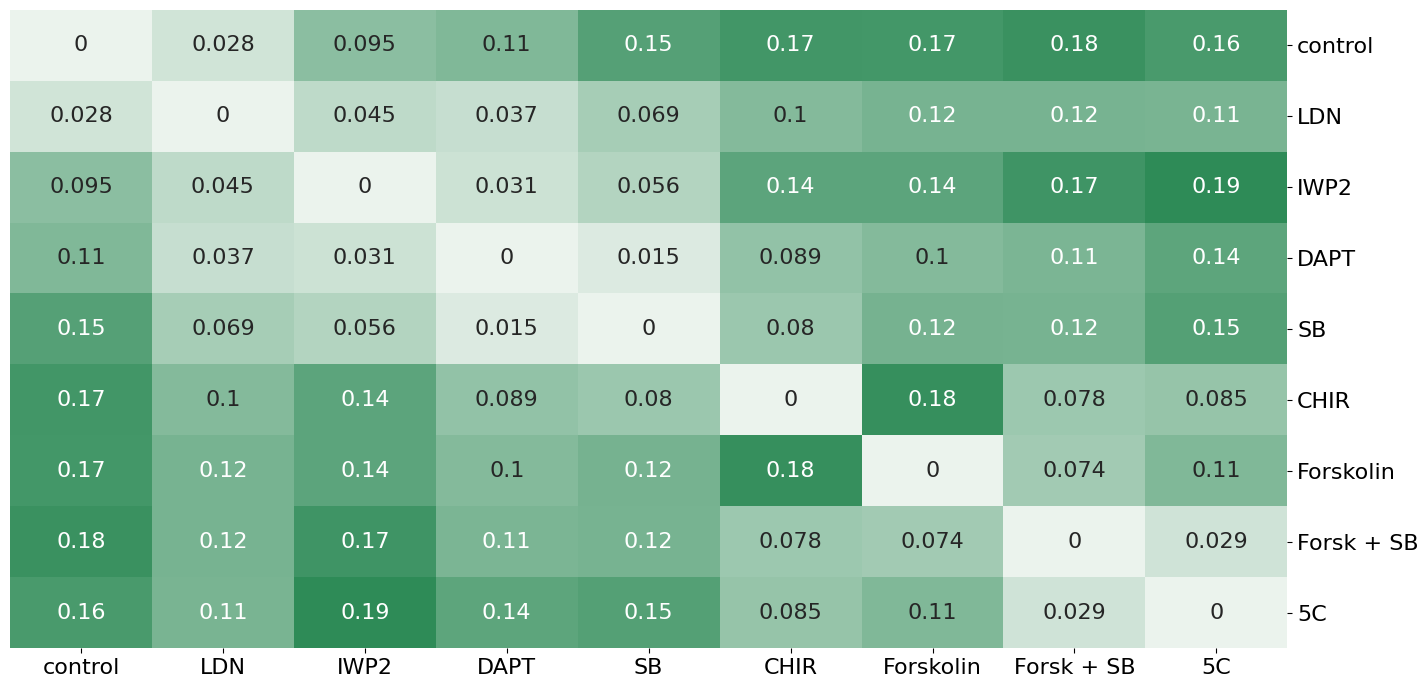

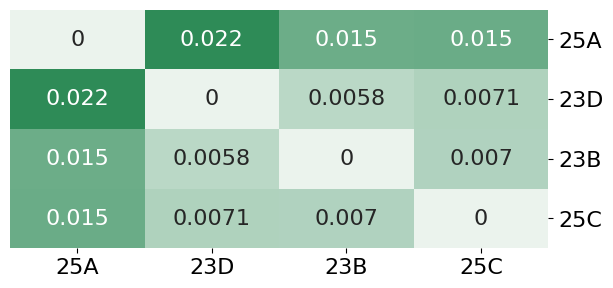

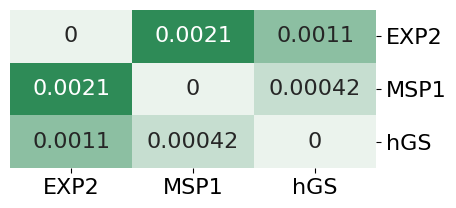

In [36]:
# Generating distance matrices
latent_space_df = pd.read_csv(embeddings_path)
for feature in comparison_groups:
    figure_path = os.path.join(paths['FA_latent_space_matrices_folder'], '{}_silhouette_scores_of_{}.png'.format(vae_identifier, feature))
    labels = [str(l) for l in df[feature]]
    if len(np.unique(labels)) > 1:
        mean, scores = evaluate_clusters.get_sillhouette_scores(latent_space_df, labels)
        ls = label_settings[feature] if label_settings and feature in label_settings.keys() else None
        evaluate_clusters.plot_distance_matrix(scores, show=True, save_path=figure_path, label_settings=ls)

# Dimensionality reduction
Next we perform dimensionality reduction on the embeddings produced by the VAE.
- **dimensionality_reducer** is the technique used to go from the N-dimensional embeddings to 2-dimensional embeddings. Can be 'umap', 'tsne' or 'pca'.


In [37]:
dimensionality_reducer = 'umap'

In [38]:
lowdim_embeddings_path = os.path.join(paths['FA_lowdim_embeddings_folder'], '{}_{}.csv'.format(vae_identifier, dimensionality_reducer))

if not os.path.exists(lowdim_embeddings_path):
    dimensionality_reduction.reduce(dimensionality_reducer, embedding_df, save_path=lowdim_embeddings_path, n_components=2)
else:
    print('Found 2D embeddings in {}, using those instead.'.format(lowdim_embeddings_path))

Found 2D embeddings in /mnt/DATA1/anton/pipeline_files/feature_analysis/lowdim_embeddings/6c_RelDrugs_hsp-dapi_VAE1_umap.csv, using those instead.


### Latent space plotting
Next, we plot the latent space

In [39]:
marker_size = 1
alpha = 0.8
gradual = {'foi': True, 'strain': False, 'drug': False}
colormaps = {'foi': 'viridis', 'strain': 'Dark2', 'drug': 'tab10'}

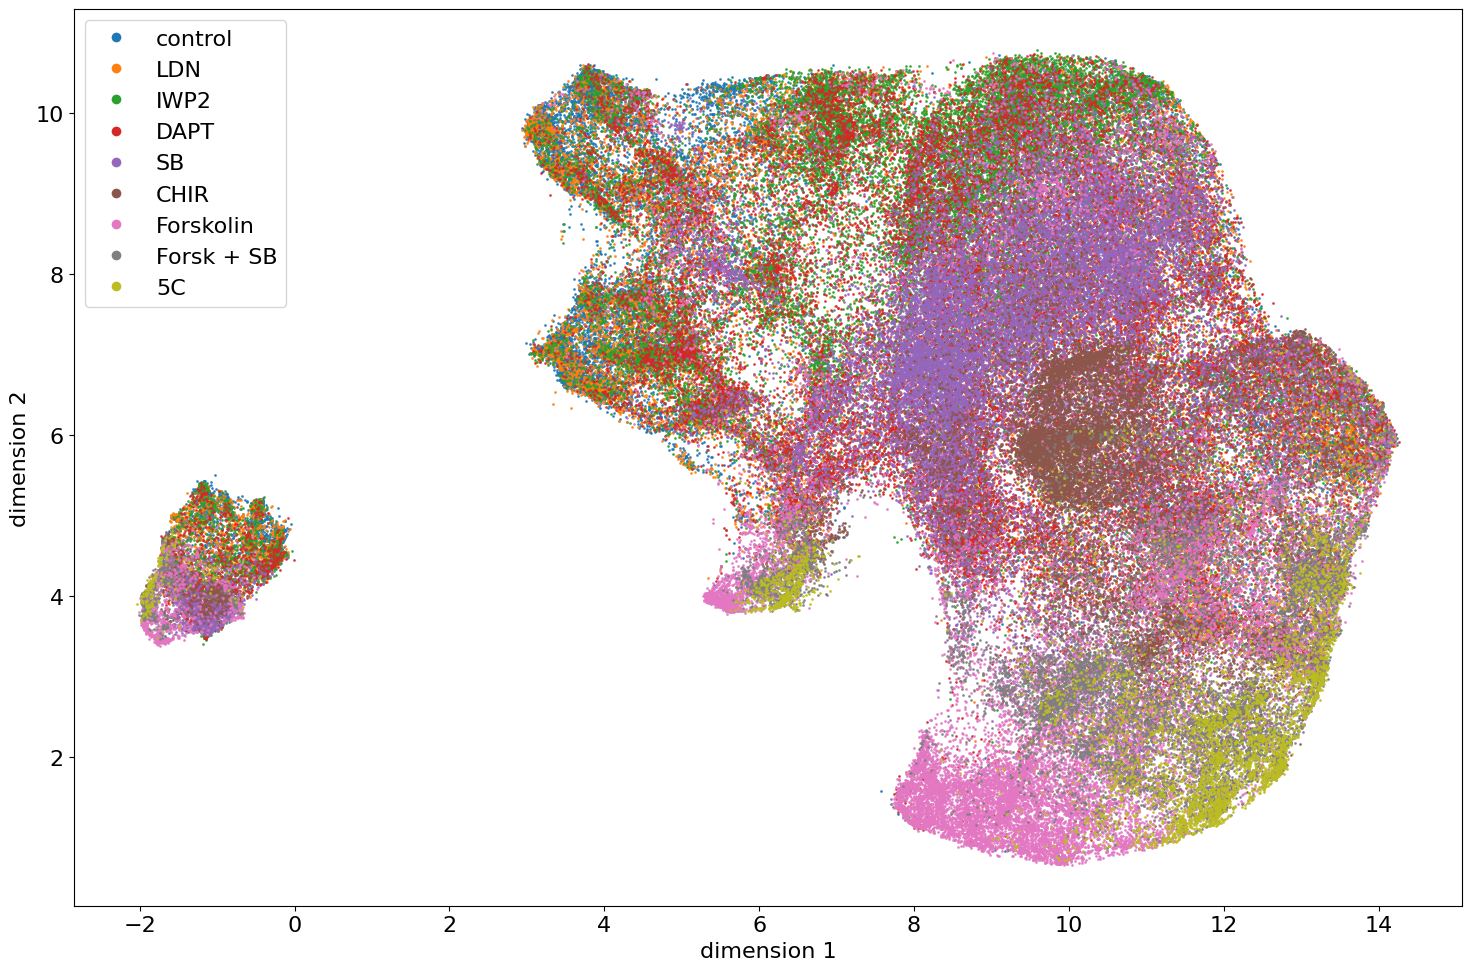

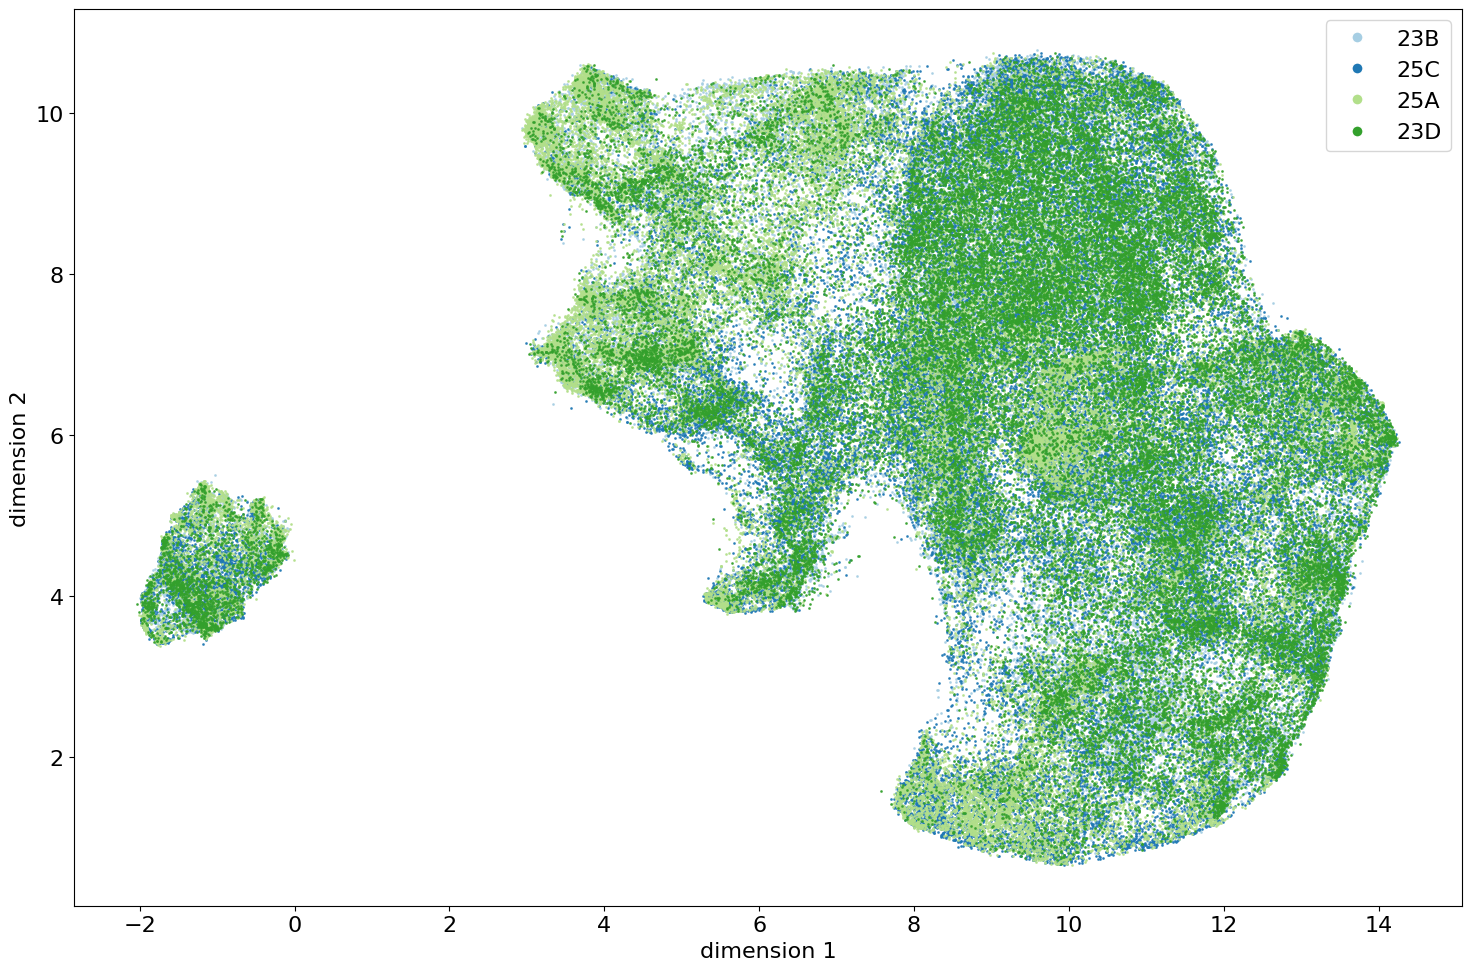

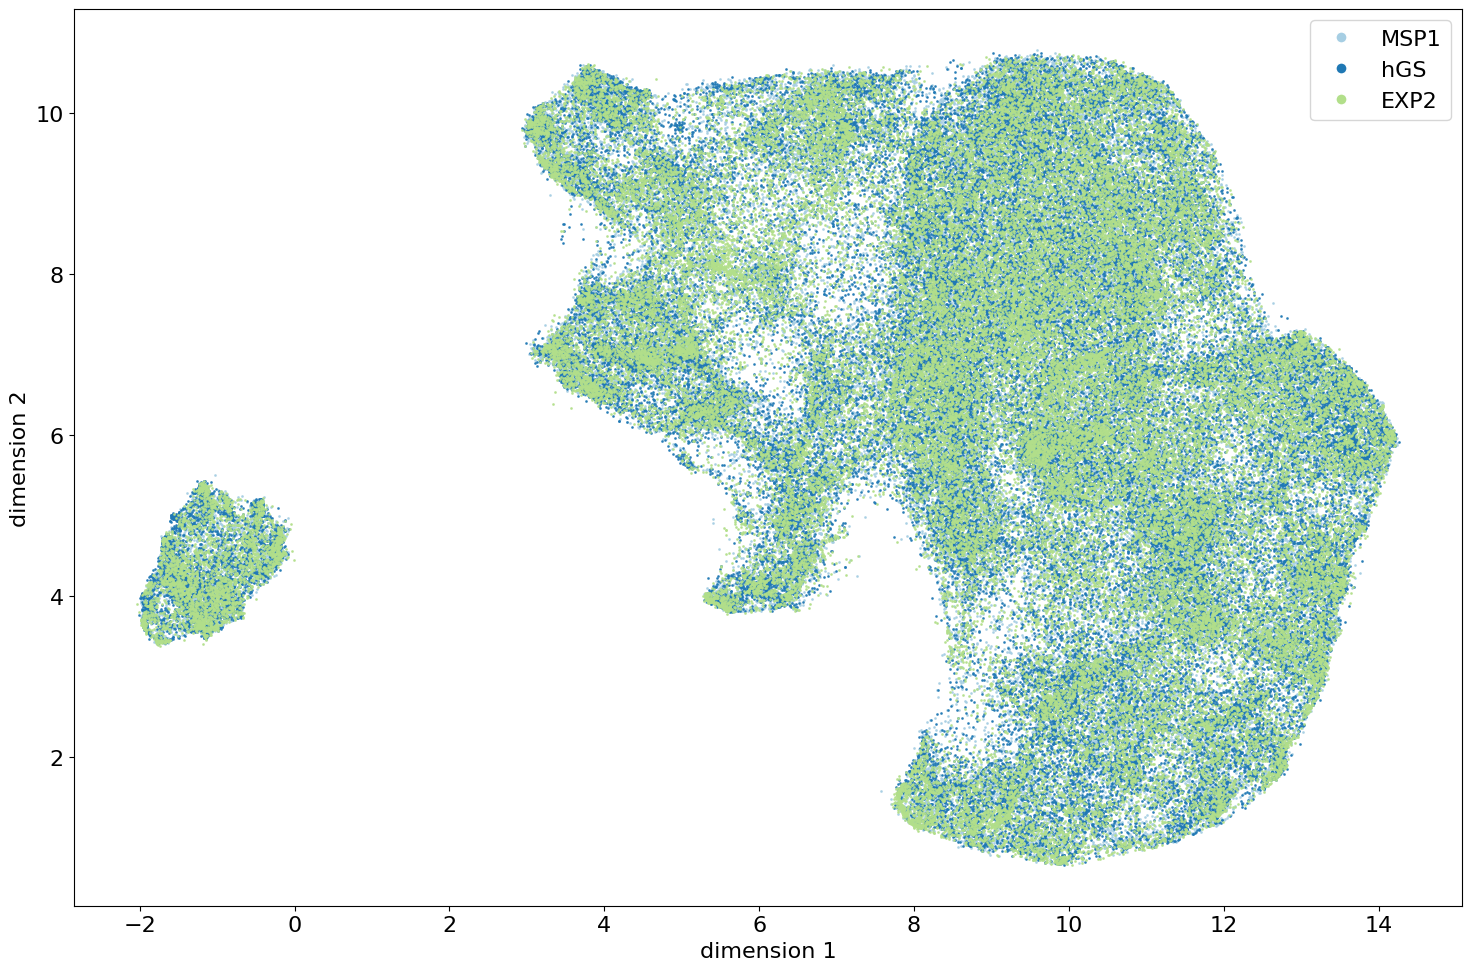

In [40]:
# Dimensionality reduction plotting
for feature in comparison_groups:
    labels = df[feature]

    if len(np.unique(labels)) > 1:

        scatterplot_path = os.path.join(paths['FA_latent_space_plots_folder'], '{}_{}-of-{}.png'.format(vae_identifier, dimensionality_reducer.upper(), feature))
        title = None# '{} of {}'.format(dimensionality_reducer.upper(), feature)
        ls = label_settings[feature] if label_settings and feature in label_settings.keys() else None
        colormap = colormaps[feature] if colormaps and feature in colormaps.keys() else 'Paired'
        do_gradual = gradual[feature] if gradual and feature in gradual.keys() else None
        plot_lowdim.plot(lowdim_embeddings_path, labels, title=title, save_path=scatterplot_path, show=True, marker_size=marker_size, alpha=alpha, colormap=colormap, label_settings=ls, gradual=do_gradual, figsize=(15,10))